## Notebook to play with CT data from a XML file

### To do list:
•Save the volume data properly as .xml. The metadata should be correct so StructuralInsight could visualize it nice

•Load all the CT volumes from a folder to use as train/test dataset. **check!**

In [1]:
import torch
import torch.utils.data
from matplotlib import pyplot as plt
import SimpleITK as sitk
import os
import ReadWriteXML as rw

In [2]:
cts_dir = r'C:\Users\Juanig\Desktop\ct images\Ground Truth'

#### Opening a file and loading its data as an array

In [3]:
file = '5a_500FBPMedianSlices.xml' 
path = cts_dir + '\\' + file
itk_volume = rw.OpenXML(path, kind = 'Slices')
volume = sitk.GetArrayFromImage(itk_volume)

#### Displaying a random slice

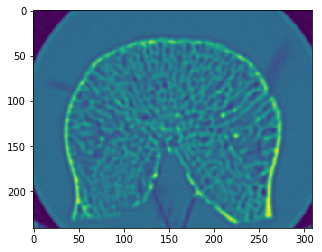

In [4]:
plt.imshow(volume[50][:][:])
plt.show()

#### As a tensor

In [5]:
tensor_volume = torch.from_numpy(volume)
print(tensor_volume.size())
print(tensor_volume.dim())

torch.Size([103, 241, 309])
3


#### Create a list of the file names of the slices CTs

In [6]:
cts_files = [f for f in os.listdir(cts_dir) if os.path.isfile(os.path.join(cts_dir, f))]
cts_slices_files = list(filter(lambda x: 'Slices.xml' in x, cts_files))
cts_slices_files

['5a_500FBPMedianSlices.xml',
 '5a_XCTSlices.xml',
 '5b_500FBPMedianSlices.xml',
 '5b_XCTSlices.xml',
 '6c_500FBPMedianSlices.xml',
 '6c_XCTSlices.xml',
 '8b_500FBPMedianSlices.xml',
 '8b_XCTSlices.xml',
 'V8_500FBPMedianSlices.xml',
 'V8_XCTSlices.xml']

#### Create a list with the volumes, as numpy arrays

In [31]:
volumes_list = []
for f in cts_slices_files:
    f_path = cts_dir + '\\' + f
    itk_volume = rw.OpenXML(f_path, kind = 'Slices')
    volume = sitk.GetArrayFromImage(itk_volume)
    volumes_list.append(volume)


#### Inspecting the dimensions of the volumes

In [32]:
#amount of volumes
print(len(volumes_list))
#dimensions of the first volume
print(len( volumes_list[0].shape) )
#shapes of the volumes
for v in volumes_list:
    print(v.shape)

#copy of all the data
volumes_list_backup = volumes_list.copy()

10
3
(103, 241, 309)
(103, 241, 309)
(105, 258, 352)
(105, 258, 352)
(100, 268, 321)
(100, 268, 321)
(101, 255, 325)
(101, 255, 325)
(100, 272, 291)
(100, 272, 291)


### The following step would be to create a torch.utils.data.DataLoader containing the volumes as tensors.
## __The issue__ : volumes of different size!!

In [29]:
#this could be done if all the volumes had the same shape
volumes_list = volumes_list_backup.copy()
volumes_list = [torch.from_numpy( v ) for v in volumes_list]
volumes_tensor = torch.stack(volumes_list)

TypeError: expected np.ndarray (got Tensor)

So, as an example of what to be done:

In [45]:
#now volumes_tensor is just one volume for examplification:
volumes_list = volumes_list_backup.copy()
volumes_tensor = torch.from_numpy(volumes_list[0])
train_data = torch.utils.data.TensorDataset(volumes_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 1, shuffle = True)

## Testing 3D conv
## To have in mind for real work!!!: Voxel size is anisotropic! (The sizes are in the header of the .xml)

In [81]:
#input tensor:
x = volumes_tensor.clone()

#Add two dimensions to this vector:
x.unsqueeze_(0)    #One dimension for the batch dimension
x.unsqueeze_(0)    #One dimension to note that my volume has one channel

#convolution layer: 
#   1 channel as input, 
#   one channel as output (this implies there is only one filter)
#   kernel size 3x3x3
#   stride of one for each dimension
conv_layer = torch.nn.Conv3d(1, 1, (3,3,3), stride = (1,1,1) )

#apply convolution
y = conv_layer(x)
print('{} \n' .format( y.shape ) )

#lets inspect the kernel:
kernel = conv_layer.weight.data.numpy()

print( '{}'.format( kernel[0][0] ) )

torch.Size([1, 1, 101, 239, 307]) 

[[[ 0.1791281  -0.17299908 -0.13695961]
  [-0.08669049 -0.17308633 -0.04385498]
  [ 0.14725514  0.17472638 -0.07936963]]

 [[ 0.17969383 -0.1099484  -0.12297619]
  [ 0.17535038  0.06371684  0.13202642]
  [ 0.12077941 -0.16267556 -0.08680712]]

 [[-0.02460544  0.0279635   0.19045733]
  [-0.04119907  0.05611524 -0.1385087 ]
  [ 0.13445683 -0.1033768  -0.17192568]]]
